# Learning to optimize parametric Quadratic Programming (pQP) and  Quadratically Constrained QP (pQCQP) problems using Neuromancer.


This is an interactive notebook based on the python script [Part_2_LearnToOptimize_pQP.py](./Part_2_LearnToOptimize_pQP.py).  

Problem formulation pQP:
    $$
    \begin{align}
    &\text{minimize } &&   x^2 + y^2\\
    &\text{subject to} &&  -x - y + p1 \le 0\\
    &  &&    x + y - p1 - 5 \le 0\\
    &  &&    x - y + p2 - 5 \le 0\\
    &  &&   -x + y - p2  \le 0\\
    \end{align}
    $$


Problem formulation pQCQP:
    $$
    \begin{align}
    &\text{minimize } &&   x^2 + y^2\\
    &\text{subject to} &&  -x - y + p1 \le 0\\
    &  &&     x^2 + y^2 \le p2^2\\
    \end{align}
    $$

with parameters $p, a$ and decision variables $x, y$.

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [1]:
!pip install --upgrade matplotlib

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1


In [4]:
!pip install setuptools==61.0.0 casadi mlflow torchdiffeq dill pyts plum-dispatch==1.7.3 --user
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps --user

  Using cached setuptools-61.0.0-py3-none-any.whl (1.1 MB)
  Using cached casadi-3.6.3-cp39-none-win_amd64.whl (39.7 MB)
  Using cached mlflow-2.3.2-py3-none-any.whl (17.7 MB)
  Using cached plum_dispatch-2.0.1-py3-none-any.whl (27 kB)
  Using cached pyarrow-11.0.0-cp39-cp39-win_amd64.whl (20.6 MB)
  Using cached alembic-1.11.1-py3-none-any.whl (224 kB)
  Using cached GitPython-3.1.31-py3-none-any.whl (184 kB)
  Using cached waitress-2.1.2-py3-none-any.whl (57 kB)
  Using cached databricks_cli-0.17.7-py3-none-any.whl
  Using cached sqlparse-0.4.4-py3-none-any.whl (41 kB)
  Using cached docker-6.1.2-py3-none-any.whl (148 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl (7.9 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached beartype-0.14.0-py3-none-any.whl (720 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Using cached pywin32-306-cp39-cp39-win_amd64.whl (9.3 MB)
  Using cached gitdb

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 

  Cloning https://github.com/pnnl/neuromancer.git (to revision master) to c:\users\drgo694\appdata\local\temp\pip-req-build-fhgtva59
  Resolved https://github.com/pnnl/neuromancer.git to commit ac646b36df18fe192f2a4ec2c88f1995c9ad759a
  Created wheel for neuromancer: filename=neuromancer-1.3.1-py3-none-any.whl size=96253 sha256=517749b59e623dab94b7bb1afa416272f98044b04c4440b0e3656987ac9a2ed6
  Stored in directory: C:\Users\drgo694\AppData\Local\Temp\pip-ephem-wheel-cache-xm7vts_0\wheels\cf\58\0e\fa96fde974dfb3196e8a260d0b557130bfa1defffda27af33f
Successfully built neuromancer


  Running command git clone -q https://github.com/pnnl/neuromancer.git 'C:\Users\drgo694\AppData\Local\Temp\pip-req-build-fhgtva59'


### Import

In [1]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects

In [2]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

# Dataset

In [3]:
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed)

In [4]:
# select from 'pQP' or 'pQCQP'
problem_type = 'pQP'   

Randomly sample parameters from a uniform distribution: $0.5\le p\le2.0$;  $0.2\le a\le1.2$

In [5]:
nsim = 3000  # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = 1.0, 11.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                 "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
               "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
               "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0,
                                           collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=32, num_workers=0,
                                         collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers=0,
                                         collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

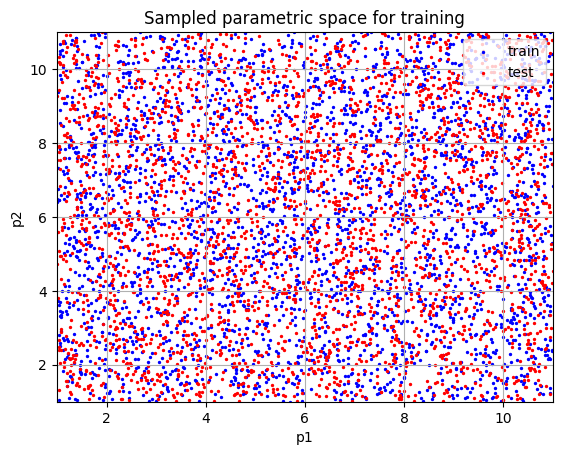

In [6]:
# visualize taining and test samples for 2D parametric space
a_train = samples_train['p1'].numpy()
p_train = samples_train['p2'].numpy()
a_dev = samples_dev['p1'].numpy()
p_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)

# pQP Formulation in NeuroMANCER

## Primal Solution Map Architecture

In [7]:
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# define symbolic solution map with concatenated features (problem parameters)
xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['xi'], ['x'], name='map')
# trainable components of the problem solution
components = [features, sol_map]

## Objective and Constraints in NeuroMANCER

In [8]:
"""
variable is a basic symbolic abstraction in Neuromancer
   x = variable("variable_name")                      (instantiates new variable)  
variable construction supports:
   algebraic expressions:     x**2 + x**3 + 5     (instantiates new variable)  
   slicing:                   x[:, i]             (instantiates new variable)  
   pytorch callables:         torch.sin(x)        (instantiates new variable)  
   constraints definition:    x <= 1.0            (instantiates Constraint object) 
   objective definition:      x.minimize()        (instantiates Objective object) 
to visualize computational graph of the variable use x.show() method          
"""

# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')

# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]

# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
if problem_type == 'pQP':  # constraints for QP
    g2 = x + y - p1 - 5
    con_2 = Q_con*(g2 <= 0)
    con_2.name = 'c2'
    g3 = x - y + p2 - 5
    con_3 = Q_con*(g3 <= 0)
    con_3.name = 'c3'
    g4 = -x + y - p2
    con_4 = Q_con*(g4 <= 0)
    con_4.name = 'c4'
    constraints = [con_1, con_2, con_3, con_4]
elif problem_type == 'pQCQP':  # constraints for QCQP
    g2 = x**2+y**2 - p2**2
    con_2 = Q_con*(g2 <= 0)
    con_2.name = 'c2'
    constraints = [con_1, con_2]

In [9]:
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)

## Parametric Problem Solution in NeuroMANCER

In [10]:
lr = 0.001      # step size for gradient descent
epochs = 400    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow before early stopping

In [11]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=epochs,
    patience=patience,
    warmup=warmup)

In [12]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 122.0165786743164
epoch: 1  train_loss: 32.59975814819336
epoch: 2  train_loss: 32.42778778076172
epoch: 3  train_loss: 31.82074546813965
epoch: 4  train_loss: 34.01681900024414
epoch: 5  train_loss: 32.41518020629883
epoch: 6  train_loss: 34.889774322509766
epoch: 7  train_loss: 32.637351989746094
epoch: 8  train_loss: 31.907123565673828
epoch: 9  train_loss: 32.113197326660156
epoch: 10  train_loss: 31.718915939331055
epoch: 11  train_loss: 30.254228591918945
epoch: 12  train_loss: 30.696022033691406
epoch: 13  train_loss: 30.477611541748047
epoch: 14  train_loss: 29.670753479003906
epoch: 15  train_loss: 30.368553161621094
epoch: 16  train_loss: 30.051889419555664
epoch: 17  train_loss: 29.986270904541016
epoch: 18  train_loss: 31.145034790039062
epoch: 19  train_loss: 31.928070068359375
epoch: 20  train_loss: 29.9549560546875
epoch: 21  train_loss: 29.84853744506836
epoch: 22  train_loss: 30.21512222290039
epoch: 23  train_loss: 29.415979385375977
epoch: 24  t

epoch: 195  train_loss: 28.088043212890625
epoch: 196  train_loss: 27.793846130371094
epoch: 197  train_loss: 28.38722038269043
epoch: 198  train_loss: 27.94221305847168
epoch: 199  train_loss: 27.822595596313477
epoch: 200  train_loss: 28.653961181640625
epoch: 201  train_loss: 28.436128616333008


<All keys matched successfully>

## Get a QP solution from CVXPY as a benchmark

[CVXPY](https://www.cvxpy.org/) is an open-source tool for constrained optimization that has influenced the development of NeuroMANCER.

In [32]:
# Define the CVXPY problems.
def QP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                      [-x - y + p1 <= 0,
                       x + y - p1 - 5 <= 0,
                       x - y + p2 - 5 <= 0,
                       -x + y - p2 <= 0])
    return prob, x, y

def QCQP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                  [-x - y + p1 <= 0,
                   x ** 2 + y ** 2 - p2 ** 2 <= 0])
    return prob, x, y

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 2.50e-01 1.67e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

## Compare: NeuroMANCER vs. CVXPY

0.7767074
0.5304637


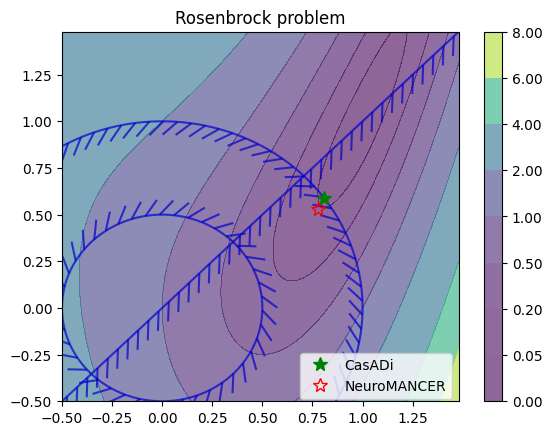

In [34]:
"""
Plots
"""
# test problem parameters
params = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
x1 = np.arange(-1.0, 10.0, 0.05)
y1 = np.arange(-1.0, 10.0, 0.05)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3)
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0

    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4)
    ax[row_id, column_id].set_title(f'QP p={p}')
    if problem_type == 'pQP':  # constraints for QP
        c1 = xx + yy - p
        c2 = -xx - yy + p + 5
        c3 = -xx + yy - p + 5
        c4 = xx - yy + p
        cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
        cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
        cg3 = ax[row_id, column_id].contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
        cg4 = ax[row_id, column_id].contour(xx, yy, c4, [0], colors='mediumblue', alpha=0.7)
        plt.setp(cg1.collections,
                 path_effects=[patheffects.withTickedStroke()], alpha=0.7)
        plt.setp(cg2.collections,
                 path_effects=[patheffects.withTickedStroke()], alpha=0.7)
        plt.setp(cg3.collections,
                 path_effects=[patheffects.withTickedStroke()], alpha=0.7)
        plt.setp(cg4.collections,
                 path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    if problem_type == 'pQCQP':  # constraints for QCQP
        c1 = xx + yy - p
        c2 = - xx**2 - yy**2 + p**2
        cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
        cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
        plt.setp(cg1.collections,
                 path_effects=[patheffects.withTickedStroke()], alpha=0.7)
        plt.setp(cg2.collections,
                 path_effects=[patheffects.withTickedStroke()], alpha=0.7)
    fig.colorbar(cp_plot, ax=ax[row_id,column_id])

    # Solve CVXPY problem
    if problem_type == 'pQP':
        prob, x, y = QP_param(p, p)
    elif problem_type == 'pQCQP':
        prob, x, y = QCQP_param(p, p)
    prob.solve()

    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                 'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()

    print(f'primal solution {problem_type} x={x.value}, y={y.value}')
    print(f'parameter p={p, p}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    print(f' f: {model_out["test_" + f.key]}')
    print(f' g1: {model_out["test_" + g1.key]}')
    print(f' g2: {model_out["test_" + g2.key]}')
    if problem_type == 'pQP':
        print(f' g3: {model_out["test_" + g3.key]}')
        print(f' g4: {model_out["test_" + g4.key]}')

    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
plt.show()
plt.show(block=True)
plt.interactive(False)

In [35]:
"""
Benchmark Solution
"""

def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x + y - p1 - 5)
    con_3_viol = np.maximum(0, x - y + p2 - 5)
    con_4_viol = np.maximum(0, -x + y - p2)
    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean

def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean

# Solve via neuromancer
t = time.time()
samples_test['name'] = 'test'
model_out = problem(samples_test)
nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()

# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QP_param(p1, p2)
    prob.solve(solver='ECOS_BB', verbose=True)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

# Evaluate neuromancer solution
print(f'Solution for {nsim} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p1, p2)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}')

# Evaluate solver solution
print(f'Solution for {nsim} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p1, p2)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}')

# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')

# stats to log
stats = {"nsim": nsim,
         "nm_time": nm_time,
         "nm_con_viol_mean": nm_con_viol_mean,
         "nm_obj_mean": nm_obj_mean,
         "solver_time": solver_time,
         "solver_con_viol_mean": solver_con_viol_mean,
         "solver_obj_mean": solver_obj_mean,
         "speedup_factor": speedup_factor,
         "err_primal": err_primal,
         "err_obj": err_obj}